# Fake Currency Detection using EfficientNet-B0 and PyTorch

This notebook demonstrates how to fine-tune a pre-trained EfficientNet-B0 model for the task of detecting fake currency. The process includes:
1.  Loading and augmenting the image data.
2.  Defining and customizing the model architecture.
3.  Implementing a training loop with validation.
4.  Evaluating the model's performance.
5.  Testing the model on a single image.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# To have plots display in the notebook
%matplotlib inline

## 1. Configuration and Hyperparameters

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Paths (assuming the same structure as the original script)
TRAIN_DIR = "dataset/training"
VALIDATION_DIR = "dataset/validation"
MODEL_SAVE_PATH = "Final_model_efficientnet.pth"

# Model and Training parameters
IMG_HEIGHT = 224 # EfficientNet-B0 preferred size
IMG_WIDTH = 224
BATCH_SIZE = 8
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

Using device: cpu


## 2. Data Loading and Preprocessing

In [3]:
# Define transformations
# Use the transforms recommended by the pre-trained model
weights = models.EfficientNet_B0_Weights.DEFAULT
preprocess = weights.transforms()

train_transforms = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    preprocess,
])
validation_transforms = preprocess

# Create datasets
try:
    train_dataset = ImageFolder(root=TRAIN_DIR, transform=train_transforms)
    validation_dataset = ImageFolder(root=VALIDATION_DIR, transform=validation_transforms)
except FileNotFoundError:
    print(f"Error: Dataset directory not found.")
    print(f"Please ensure '{TRAIN_DIR}' and '{VALIDATION_DIR}' exist and contain subdirectories for each class.")
    # In a notebook, we don't want to exit, so we just print the error.


# Create data loaders
# Use os.cpu_count() to leverage available CPU cores for data loading
# Note: On Windows, multiprocessing with num_workers > 0 can sometimes cause issues in Jupyter.
# If you encounter a BrokenPipeError or a similar error, set num_workers to 0.
num_workers = os.cpu_count() if os.name != 'nt' else 0 
print(f"Using {num_workers} workers for data loading.")
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers, pin_memory=True if DEVICE.type == 'cuda' else False)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers, pin_memory=True if DEVICE.type == 'cuda' else False)

print(f"Found {len(train_dataset)} images in training folder, belonging to {len(train_dataset.classes)} classes.")
print(f"Found {len(validation_dataset)} images in validation folder, belonging to {len(validation_dataset.classes)} classes.")

# Dynamically get class list and number of classes
class_list = train_dataset.classes
num_classes = len(class_list)
print(f"Class list determined from folders: {class_list}")

Using 0 workers for data loading.
Found 2774 images in training folder, belonging to 2 classes.
Found 592 images in validation folder, belonging to 2 classes.
Class list determined from folders: ['fake', 'real']


## 3. Model Definition

In [4]:
def create_finetune_model(num_classes, weights_enum=models.EfficientNet_B0_Weights.DEFAULT):
    """Creates, customizes, and returns the EfficientNet model for fine-tuning."""
    # Load a pre-trained EfficientNet-B0 model
    model = models.efficientnet_b0(weights=weights_enum)

    # Freeze all the parameters in the feature extraction part of the model if using pre-trained weights
    if weights_enum is not None:
        for param in model.parameters():
            param.requires_grad = False

    # Replace the classifier with a new one that matches the Keras architecture
    # Original Keras: Flatten, Dense(1024), Dropout(0.5), Dense(1024), Dropout(0.5), Dense(2)
    in_features = model.classifier[1].in_features
    FC_Layers = [1024, 1024]
    dropout = 0.5

    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features, FC_Layers[0]), nn.ReLU(), nn.Dropout(dropout),
        nn.Linear(FC_Layers[0], FC_Layers[1]), nn.ReLU(), nn.Dropout(dropout),
        nn.Linear(FC_Layers[1], num_classes)
    )
    return model

## 4. Evaluation and Plotting Functions

In [5]:
def plot_training_history(history, save_path):
    """Plots the training and validation accuracy and loss."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_acc'], label='Train Accuracy')
    ax1.plot(history['val_acc'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='upper left')

    ax2.plot(history['train_loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper left')

    print(f"Saving training history plot to {save_path}...")
    plt.savefig(save_path)
    plt.show() # Display the plot in the notebook
    plt.close(fig) # Close the figure to free up memory

def evaluate_model(model_path, validation_loader, class_list):
    """Loads the best model and evaluates it on the validation set."""
    if not os.path.exists(model_path):
        print(f"Model file not found at {model_path}. Please train the model first.")
        return

    print("\n--- Evaluating model on validation set ---")
    # Load the best model for evaluation, ensuring it's mapped to the correct device
    model = create_finetune_model(len(class_list), weights_enum=None)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = [] # For ROC curve

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            
            # Get predictions for classification report and confusion matrix
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Get probabilities for the positive class for the ROC curve
            # This is specific to binary classification
            if len(class_list) == 2:
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                # Assuming the positive class is at index 1 (e.g., 'real')
                all_probs.extend(probabilities[:, 1].cpu().numpy())

    print("\nClassification Report:")
    report = classification_report(all_labels, all_preds, target_names=class_list, digits=4)
    print(report)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_list)
    disp.plot() # This draws the plot on a new figure
    cm_save_path = "confusion_matrix.png"
    print(f"Saving confusion matrix to {cm_save_path}...")
    plt.savefig(cm_save_path)
    plt.show() # Display the plot in the notebook
    plt.close() # Close the figure to free up memory

    # --- ROC-AUC Curve Plotting ---
    if len(class_list) == 2 and all_probs:
        print("\nROC-AUC Curve:")
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        
        roc_save_path = "roc_auc_curve.png"
        print(f"Saving ROC-AUC curve to {roc_save_path}...")
        plt.savefig(roc_save_path)
        plt.show()
        plt.close()
    elif len(class_list) != 2:
        print("\nROC-AUC curve is only generated for binary classification tasks.")


def test_single_image(model_path, image_path, transforms, class_list):
    if not os.path.exists(model_path):
        print(f"Model file not found at {model_path}. Please train the model first.")
        return

    if not os.path.exists(image_path):
        print(f"Test image not found at {image_path}. Please check the path.")
        return

    # Load the model with the best weights
    # We need to define the model architecture again before loading the state dict
    test_model = create_finetune_model(len(class_list), weights_enum=None) # No pre-trained weights needed
    test_model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    test_model = test_model.to(DEVICE)
    test_model.eval()

    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transforms(img).unsqueeze(0).to(DEVICE)

    # Display the image
    plt.imshow(img)
    plt.title(f"Testing Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show() # This is intentionally left to show the user the image being tested

    # Predict
    with torch.no_grad():
        output = test_model(img_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        _, pred_idx = torch.max(output, 1)
        predicted_class = class_list[pred_idx.item()]

    print(f"Prediction: {predicted_class}")
    print("Probabilities:")
    for i, class_name in enumerate(class_list):
        print(f"  - {class_name}: {probabilities[i]:.4f}")

## 5. Training Loop Function

In [6]:
def train_model(model, criterion, optimizer, scheduler, train_loader, validation_loader, class_list):
    best_val_accuracy = 0.0
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    start_time = time.time()

    train_dataset_size = len(train_loader.dataset)
    validation_dataset_size = len(validation_loader.dataset)

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}\n' + '-'*10)
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_dataset_size
        epoch_acc = running_corrects.double() / train_dataset_size

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / validation_dataset_size
        val_epoch_acc = val_corrects.double() / validation_dataset_size

        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.item())

        # Step the scheduler based on validation loss
        scheduler.step(val_epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        # Save the model if it has the best validation accuracy so far
        if val_epoch_acc > best_val_accuracy:
            best_val_accuracy = val_epoch_acc
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f'New best model saved to {MODEL_SAVE_PATH} (Val Acc: {val_epoch_acc:.4f})')

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_val_accuracy:4f}')
    
    # Plot training history
    plot_training_history(history, "training_history_plot.png")

    # Automatically evaluate the best model after training
    print("\n\n--- Automatically evaluating best model on validation set ---")
    evaluate_model(MODEL_SAVE_PATH, validation_loader, class_list)
    
    return history

## 6. Train the Model

The following cell will start the training process. It will:
1. Create a new instance of the `EfficientNet-B0` model with a custom classifier.
2. Define the loss function (`CrossEntropyLoss`), optimizer (`Adam`), and a learning rate scheduler (`ReduceLROnPlateau`).
3. Call the `train_model` function to start training and validation for the number of epochs defined in the configuration.
4. The best model based on validation accuracy will be saved to `Final_model_efficientnet.pth`.
5. After training, it will automatically plot the training history and evaluate the best model on the validation set.

Model architecture created for fine-tuning.
Classifier to be trained:
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1280, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=1024, out_features=2, bias=True)
)
Epoch 1/20
----------
Train Loss: 0.5163 Acc: 0.7462 | Val Loss: 0.4040 Acc: 0.8497
New best model saved to Final_model_efficientnet.pth (Val Acc: 0.8497)
Epoch 2/20
----------
Train Loss: 0.4391 Acc: 0.7981 | Val Loss: 0.3258 Acc: 0.8598
New best model saved to Final_model_efficientnet.pth (Val Acc: 0.8598)
Epoch 3/20
----------
Train Loss: 0.4156 Acc: 0.8043 | Val Loss: 0.3576 Acc: 0.8361
Epoch 4/20
----------
Train Loss: 0.4123 Acc: 0.7952 | Val Loss: 0.3134 Acc: 0.8480
Epoch 5/20
----------
Train Loss: 0.4267 Acc: 0.7996 | Val Loss: 0.3409 Acc: 0.8530
Epoch 6/20
----------
Train L

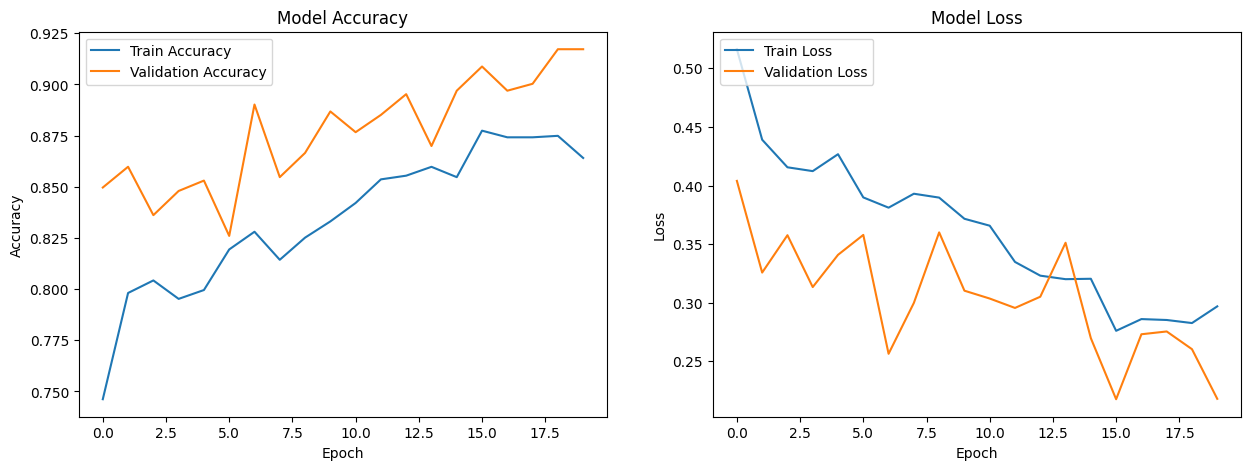



--- Automatically evaluating best model on validation set ---

--- Evaluating model on validation set ---

Classification Report:
              precision    recall  f1-score   support

        fake     0.9524    0.8784    0.9139       296
        real     0.8871    0.9561    0.9203       296

    accuracy                         0.9172       592
   macro avg     0.9198    0.9172    0.9171       592
weighted avg     0.9198    0.9172    0.9171       592


Confusion Matrix:
Saving confusion matrix to confusion_matrix.png...


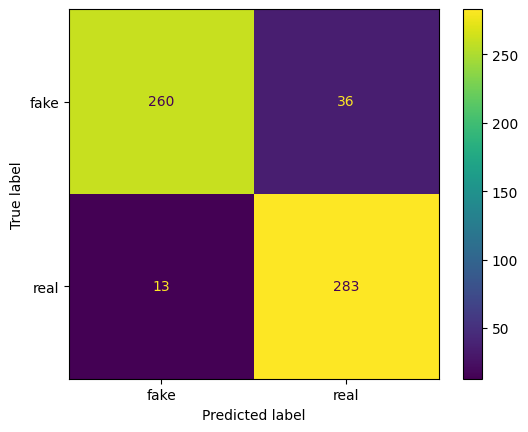


ROC-AUC Curve:
Saving ROC-AUC curve to roc_auc_curve.png...


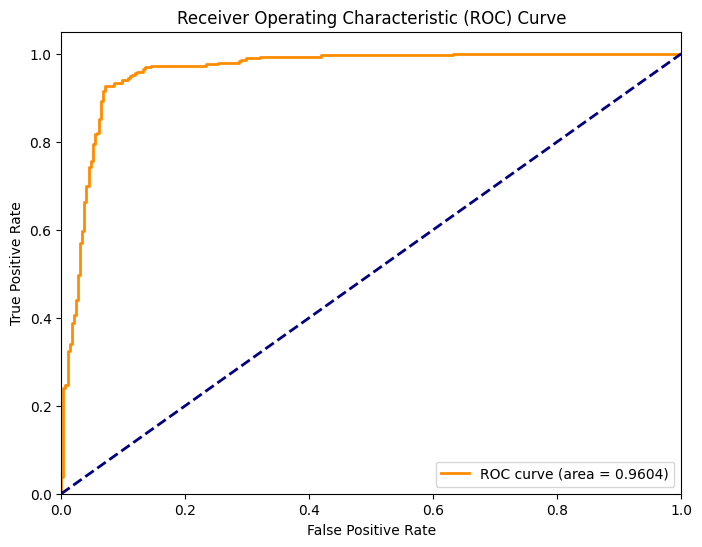

In [7]:
# Create the model for training
model = create_finetune_model(num_classes, weights_enum=weights)
model = model.to(DEVICE)
print("Model architecture created for fine-tuning.")
print("Classifier to be trained:")
print(model.classifier)

# Setup optimizer and scheduler
criterion = nn.CrossEntropyLoss()
# We only want to train the parameters of the new classifier
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Start training
# The train_model function will also save the best model and evaluate it at the end
history = train_model(model, criterion, optimizer, scheduler, train_loader, validation_loader, class_list)

## 7. Evaluate the Saved Model

This cell loads the best model saved during training (`Final_model_efficientnet.pth`) and evaluates its performance on the validation dataset. It will print a classification report and display a confusion matrix.

You can run this cell independently after training is complete to re-evaluate the best saved model.


--- Evaluating model on validation set ---

Classification Report:
              precision    recall  f1-score   support

        fake     0.9524    0.8784    0.9139       296
        real     0.8871    0.9561    0.9203       296

    accuracy                         0.9172       592
   macro avg     0.9198    0.9172    0.9171       592
weighted avg     0.9198    0.9172    0.9171       592


Confusion Matrix:
Saving confusion matrix to confusion_matrix.png...


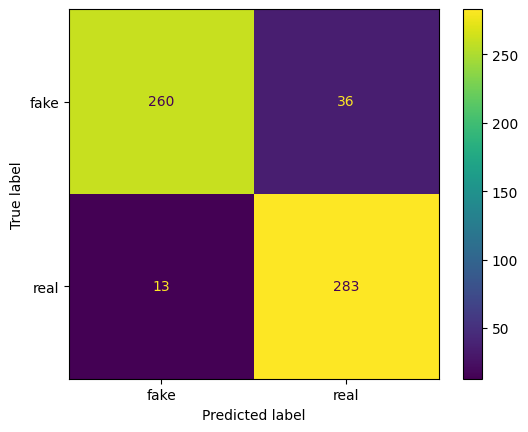


ROC-AUC Curve:
Saving ROC-AUC curve to roc_auc_curve.png...


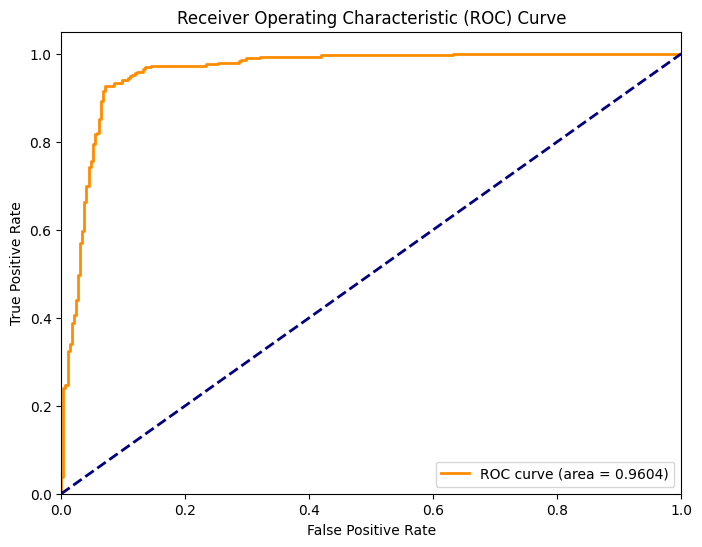

In [8]:
evaluate_model(MODEL_SAVE_PATH, validation_loader, class_list)

## 8. Test on a Single Image

Use this cell to test the trained model on a new, unseen image.

**Instructions:**
1.  Place your test image in a known directory.
2.  Update the `test_image_path` variable below to the full path of your image.
3.  Run the cell.

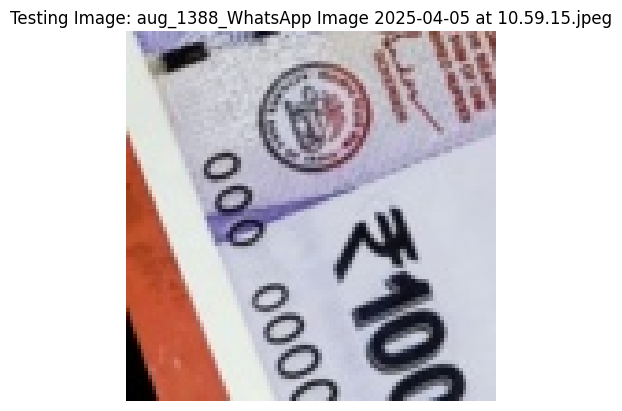

Prediction: fake
Probabilities:
  - fake: 0.9996
  - real: 0.0004


In [9]:
# --- Define the path to your test image here ---
# IMPORTANT: On Windows, you must format the path correctly for Python.
# Option 1 (recommended): Use a raw string by adding an 'r' before the quotes.
# test_image_path = r"C:\Users\your_name\image.jpg"
#
# Option 2: Use forward slashes instead of backslashes.
# test_image_path = "C:/Users/your_name/image.jpg"

test_image_path = r"C:\Users\singh\Downloads\Fake-currency-detection-main\dataset\testing\fake\aug_1388_WhatsApp Image 2025-04-05 at 10.59.15.jpeg" # <-- CHANGE THIS LINE IF NEEDED

# This check looks for the ORIGINAL placeholder text, or if the file doesn't exist.
if "path/to/your/image.jpg" in test_image_path or not os.path.exists(test_image_path):
    print("Please update the `test_image_path` variable to a valid path for your test image.")
    print(f"Current path: '{test_image_path}'")
    if not os.path.exists(test_image_path):
        print("Error: This file does not exist. Please double-check the path and filename.")
else:
    test_single_image(
        model_path=MODEL_SAVE_PATH,
        image_path=test_image_path,
        transforms=validation_transforms, # Use the same transforms as validation
        class_list=class_list
    )

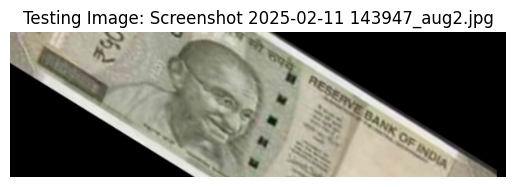

Prediction: real
Probabilities:
  - fake: 0.0134
  - real: 0.9866


In [10]:
test_image_path = r"C:\Users\singh\Downloads\Fake-currency-detection-main\dataset\testing\real\Screenshot 2025-02-11 143947_aug2.jpg" # <-- CHANGE THIS LINE IF NEEDED

# This check looks for the ORIGINAL placeholder text, or if the file doesn't exist.
if "path/to/your/image.jpg" in test_image_path or not os.path.exists(test_image_path):
    print("Please update the `test_image_path` variable to a valid path for your test image.")
    print(f"Current path: '{test_image_path}'")
    if not os.path.exists(test_image_path):
        print("Error: This file does not exist. Please double-check the path and filename.")
else:
    test_single_image(
        model_path=MODEL_SAVE_PATH,
        image_path=test_image_path,
        transforms=validation_transforms, # Use the same transforms as validation
        class_list=class_list
    )